# **Goal-Oriented Agents for Real-Time Task Automation in Elderly Care**

---

**DESCRIPTION:**

The dataset used to train this model was obtained from the paper "On Sweat Analysis for Quantitative Estimation of Dehydration during Physical Exercise" published in IEEE Access.

**Citation:** Ring, M., Lohmueller, C., Rauh, M., and Eskofier, B. M. (2015). On sweat analysis for quantitative estimation of dehydration during physical exercise. Proceedings of the 37th Annual International Conference of the IEEE Engineering in Medicine and Biology Society. Milan, Italy, pp. 7011-7014.

Link to paper: https://ieeexplore.ieee.org/document/7320006/

Link to Dataset [Open Acess]: https://physionet.org/content/qde/1.0.0/

---

**Steps:**
* Load the Data
* Explore the Data
* Adjust the data to age group (>= 60)
* Calculate Baseline Weight and Total Body Water Loss (TBW) % for the new age group
* Categorize TBW Loss % into different Levels of Dehydration Risk
* Explore Newly Adjusted Data
* Adding Synthetic Data to Train Model on Moderate and Severe Risk Cases
* Derive the Target Field
* Split the Data
* Train the Model
* Evaluate the Model
* Export Model

---

**About the dehydration estimation dataset:** This dataset is focused on the quantitative estimation of dehydration, specifically total body water loss. The data was collected during a 120-minute physical exercise session on an indoor treadmill, partitioned into 8 intervals. During 8-minute resting breaks after each interval, measurements of bioimpedance, temperature, sweat, and saliva were taken. Total body water loss was determined by the change in body weight using a high-precision scale.

**Updated dataset for Elderly Patients:**

For this model, the following fields from the QDE dataset were used:

`'id', 'age [years]', 'running interval', 'weight measured using Kern DE 150K2D [kg]', 'total body water using InBody 720 [l]'`

Adjustments were made to the 'age [years]' field by adding an offset of 40 to simulate an older age group (>= 60). The following formula was used:

`df_selected['age [years]'] = df_selected['age [years]'] + age_offset`

Baseline weight was calculated for each individual at running interval 0.

Absolute weight loss was calculated as follows:

`Baseline Weight - weight measured using Kern DE 150K2D [kg]`

The TBW Loss % was then calculated as follows:

`(Absolute Weight Loss / Baseline Weight) * 100`

Finally, an Adjusted TBW Loss % was calculated by multiplying the TBW Loss % by 1.2, using the following formula:

`df_selected['Adjusted TBW Loss %'] = df_selected['TBW Loss %'] * 1.2`

(The scaling factor of 1.2 was obtained with the assumption that the normal TBW in Younger Adults is 60%, whereas in Older Adults it decreases to approximately 50%.)

In addition to the adjusted data values, synthetic data was appended to the existing dataset to train the model on Moderate and Severe Dehydration.

The synthetic data was derived as follows:

Synthetic 'Adjusted TBW Loss %' values were generated within the ranges of 5-10% for Moderate Dehydration and >=10% for Severe Dehydration. 'Absolute Weight Loss' for these synthetic samples was estimated using the average ratio of 'Adjusted TBW Loss %' to 'Absolute Weight Loss' observed in the original data. The formula used for this estimation was:

`Absolute Weight Loss = Synthetic Adjusted TBW Loss % / Average Ratio`

These adjusted percentages were used to categorize dehydration risk into **Euhydration/No Dehydration, Mild Dehydration, Moderate Dehydration, or Severe Dehydration** which will help in predicting the dehydration risk.

---



# 1. Adding Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load the Data

**Mounting to Google Drive to access dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Run the following command to check the current working directory
# !pwd

Mounted at /content/drive


**Locating the dataset**

In [3]:
!ls /content/drive/MyDrive/QDE/dehydration_estimation.csv

/content/drive/MyDrive/QDE/dehydration_estimation.csv


**Choose the dataset and read its content using pandas library**

In [4]:
df = pd.read_csv("/content/drive/MyDrive/QDE/dehydration_estimation.csv")

In [5]:
df.head(15)

,id,age [years],height [cm],running speed [km/h],running interval,weight measured using Kern DE 150K2D [kg],weight measured using InBody 720 [kg],total body water using InBody 720 [l],impedance right arm at 1000kHz [Ohm],impedance left arm at 1000kHz [Ohm],...,temperature lower leg [degree C],sweat chloride [mmol/l],sweat osmolality [mmol/kg],salivary amylase [units/l],salivary chloride [mmol/l],salivary cortisol [ng/ml],salivary cortisone [ng/ml],salivary osmolality [mmol/kg],salivary potassium [mmol/l],salivary protein concentration [mg/l]
0,1,29.0,190.0,8.0,0,85.515,85.90,54.0,231.27,232.63,...,31.9,NaN,NaN,NaN,28.0,NaN,NaN,76.0,NaN,576.8
1,1,NaN,NaN,NaN,1,85.275,85.56,53.7,234.75,240.08,...,31.3,56.0,146.0,NaN,29.0,NaN,NaN,78.0,NaN,544.1
2,1,NaN,NaN,NaN,2,84.895,85.32,54.0,230.81,233.95,...,31.2,55.0,134.0,111700.0,35.0,1.240,11.80,84.0,37.0,537.3
3,1,NaN,NaN,NaN,3,84.540,84.90,54.0,231.96,236.32,...,30.9,53.0,123.0,NaN,38.0,0.947,10.60,95.0,38.0,595.6
4,1,NaN,NaN,NaN,4,84.185,84.48,53.9,227.03,232.07,...,31.7,36.0,185.0,154110.0,37.0,0.727,9.64,91.0,32.0,541.3
5,1,NaN,NaN,NaN,5,83.810,84.28,53.9,230.39,233.69,...,32.0,69.0,163.0,127170.0,39.0,0.806,10.80,104.0,37.0,629.7
6,1,NaN,NaN,NaN,6,83.470,83.88,53.6,234.76,236.69,...,31.4,NaN,NaN,262940.0,42.0,0.867,11.00,116.0,43.0,773.9
7,1,NaN,NaN,NaN,7,83.130,83.60,53.3,234.05,236.11,...,31.7,67.0,152.0,266060.0,41.0,NaN,NaN,115.0,44.0,915.6
8,1,NaN,NaN,NaN,8,82.840,83.16,53.3,232.22,236.72,...,31.7,70.0,165.0,243150.0,41.0,2.110,15.40,108.0,45.0,878.0
9,2,22.0,190.0,8.5,0,87.115,87.88,58.0,226.19,225.33,...,30.9,NaN,NaN,489550.0,26.0,0.461,8.08,131.0,32.0,1232.7


# 3. Exploring the Data

In [6]:
df.shape

(90, 33)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         90 non-null     int64  
 1   age [years]                                10 non-null     float64
 2   height [cm]                                10 non-null     float64
 3   running speed [km/h]                       10 non-null     float64
 4   running interval                           90 non-null     int64  
 5   weight measured using Kern DE 150K2D [kg]  90 non-null     float64
 6   weight measured using InBody 720 [kg]      90 non-null     float64
 7   total body water using InBody 720 [l]      90 non-null     float64
 8   impedance right arm at 1000kHz [Ohm]       90 non-null     float64
 9   impedance left arm at 1000kHz [Ohm]        90 non-null     float64
 10  impedance trunk at 1000kHz [

In [8]:
relevant_columns = [
    'id',
    'age [years]',
    'running interval',
    'weight measured using Kern DE 150K2D [kg]',
    'total body water using InBody 720 [l]'
]
df_selected = df[relevant_columns].copy()
df_selected.head(15)

,id,age [years],running interval,weight measured using Kern DE 150K2D [kg],total body water using InBody 720 [l]
0,1,29.0,0,85.515,54.0
1,1,NaN,1,85.275,53.7
2,1,NaN,2,84.895,54.0
3,1,NaN,3,84.540,54.0
4,1,NaN,4,84.185,53.9
5,1,NaN,5,83.810,53.9
6,1,NaN,6,83.470,53.6
7,1,NaN,7,83.130,53.3
8,1,NaN,8,82.840,53.3
9,2,22.0,0,87.115,58.0


In [9]:
df_selected.shape

(90, 5)

In [10]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         90 non-null     int64  
 1   age [years]                                10 non-null     float64
 2   running interval                           90 non-null     int64  
 3   weight measured using Kern DE 150K2D [kg]  90 non-null     float64
 4   total body water using InBody 720 [l]      90 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 3.6 KB


In [11]:
df_selected.describe().T

,count,mean,std,min,25%,50%,75%,max
id,90.0,5.500000,2.888373,1.000,3.00000,5.500,8.00,10.000
age [years],10.0,25.500000,3.719319,20.000,22.75000,26.000,28.75,30.000
running interval,90.0,4.000000,2.596454,0.000,2.00000,4.000,6.00,8.000
weight measured using Kern DE 150K2D [kg],90.0,78.113756,8.451373,53.856,76.83375,80.345,83.05,87.115
total body water using InBody 720 [l],90.0,50.511111,5.472884,36.100,49.42500,52.000,53.20,58.400


In [12]:
df_selected.isnull().sum()

,0
id,0
age [years],80
running interval,0
weight measured using Kern DE 150K2D [kg],0
total body water using InBody 720 [l],0


In [13]:
df_selected['age [years]'] = df_selected.groupby('id')['age [years]'].transform(lambda x: x.fillna(x.iloc[0]))

In [14]:
df_selected.head(15)

,id,age [years],running interval,weight measured using Kern DE 150K2D [kg],total body water using InBody 720 [l]
0,1,29.0,0,85.515,54.0
1,1,29.0,1,85.275,53.7
2,1,29.0,2,84.895,54.0
3,1,29.0,3,84.540,54.0
4,1,29.0,4,84.185,53.9
5,1,29.0,5,83.810,53.9
6,1,29.0,6,83.470,53.6
7,1,29.0,7,83.130,53.3
8,1,29.0,8,82.840,53.3
9,2,22.0,0,87.115,58.0


In [15]:
df_selected.isnull().sum()

,0
id,0
age [years],0
running interval,0
weight measured using Kern DE 150K2D [kg],0
total body water using InBody 720 [l],0


# 4. Adjusting the data to age group (>= 60)

In [16]:
age_offset = 40 # Add 40 years to shift the age range
df_selected['age [years]'] = df_selected['age [years]'] + age_offset

In [17]:
df_selected.head(15)

,id,age [years],running interval,weight measured using Kern DE 150K2D [kg],total body water using InBody 720 [l]
0,1,69.0,0,85.515,54.0
1,1,69.0,1,85.275,53.7
2,1,69.0,2,84.895,54.0
3,1,69.0,3,84.540,54.0
4,1,69.0,4,84.185,53.9
5,1,69.0,5,83.810,53.9
6,1,69.0,6,83.470,53.6
7,1,69.0,7,83.130,53.3
8,1,69.0,8,82.840,53.3
9,2,62.0,0,87.115,58.0


# 5. Calculate Baseline Weight and Total Body Water Loss (TBW) % for new age group

In [18]:
# Calculate Baseline Weight for running interval 0 for ALL individuals first
all_baseline_weights = df[df['running interval'] == 0][['id', 'weight measured using Kern DE 150K2D [kg]']].copy()
all_baseline_weights.rename(columns={'weight measured using Kern DE 150K2D [kg]': 'Baseline Weight'}, inplace=True)

In [19]:
# Ensure 'Baseline Weight' column exists in df_selected before dropping if it was created in a previous attempt
if 'Baseline Weight' in df_selected.columns:
    df_selected = df_selected.drop('Baseline Weight', axis=1)

In [20]:
# Merge the calculated baseline weights into the df_selected DataFrame
df_selected = pd.merge(df_selected, all_baseline_weights, on='id', how='left')

In [21]:
# Calculate Absolute Weight Loss and TBW Loss Percentage
df_selected['Absolute Weight Loss'] = df_selected['Baseline Weight'] - df_selected['weight measured using Kern DE 150K2D [kg]']
df_selected['TBW Loss %'] = (df_selected['Absolute Weight Loss'] / df_selected['Baseline Weight']) * 100

df_selected.head(15)

,id,age [years],running interval,weight measured using Kern DE 150K2D [kg],total body water using InBody 720 [l],Baseline Weight,Absolute Weight Loss,TBW Loss %
0,1,69.0,0,85.515,54.0,85.515,0.000,0.000000
1,1,69.0,1,85.275,53.7,85.515,0.240,0.280653
2,1,69.0,2,84.895,54.0,85.515,0.620,0.725019
3,1,69.0,3,84.540,54.0,85.515,0.975,1.140151
4,1,69.0,4,84.185,53.9,85.515,1.330,1.555283
5,1,69.0,5,83.810,53.9,85.515,1.705,1.993802
6,1,69.0,6,83.470,53.6,85.515,2.045,2.391393
7,1,69.0,7,83.130,53.3,85.515,2.385,2.788984
8,1,69.0,8,82.840,53.3,85.515,2.675,3.128106
9,2,62.0,0,87.115,58.0,87.115,0.000,0.000000


In [22]:
df_selected['Adjusted TBW Loss %'] = df_selected['TBW Loss %'] * 1.2
df_selected.head(15)

,id,age [years],running interval,weight measured using Kern DE 150K2D [kg],total body water using InBody 720 [l],Baseline Weight,Absolute Weight Loss,TBW Loss %,Adjusted TBW Loss %
0,1,69.0,0,85.515,54.0,85.515,0.000,0.000000,0.000000
1,1,69.0,1,85.275,53.7,85.515,0.240,0.280653,0.336783
2,1,69.0,2,84.895,54.0,85.515,0.620,0.725019,0.870023
3,1,69.0,3,84.540,54.0,85.515,0.975,1.140151,1.368181
4,1,69.0,4,84.185,53.9,85.515,1.330,1.555283,1.866339
5,1,69.0,5,83.810,53.9,85.515,1.705,1.993802,2.392563
6,1,69.0,6,83.470,53.6,85.515,2.045,2.391393,2.869672
7,1,69.0,7,83.130,53.3,85.515,2.385,2.788984,3.346781
8,1,69.0,8,82.840,53.3,85.515,2.675,3.128106,3.753727
9,2,62.0,0,87.115,58.0,87.115,0.000,0.000000,0.000000


# 6. Categorize TBW Loss % into different Levels of Dehydration Risk

In [23]:
def categorize_dehydration_risk(tbw_loss_percentage):
    """
    Categorizes dehydration risk based on Adjusted TBW Loss percentage.

    Args:
        tbw_loss_percentage: The adjusted total body water loss percentage.

    Returns:
        A string representing the dehydration risk category.
    """
    if tbw_loss_percentage <= 2:
        return 'Euhydrated/No Dehydration'
    elif 2 < tbw_loss_percentage < 5:
        return 'Mild Dehydration'
    elif 5 <= tbw_loss_percentage <= 10:
        return 'Moderate Dehydration'
    elif tbw_loss_percentage > 10:
        return 'Severe Dehydration'

In [24]:
df_selected['Dehydration Risk Category'] = df_selected['Adjusted TBW Loss %'].apply(categorize_dehydration_risk)
df_selected.head(15)

,id,age [years],running interval,weight measured using Kern DE 150K2D [kg],total body water using InBody 720 [l],Baseline Weight,Absolute Weight Loss,TBW Loss %,Adjusted TBW Loss %,Dehydration Risk Category
0,1,69.0,0,85.515,54.0,85.515,0.000,0.000000,0.000000,Euhydrated/No Dehydration
1,1,69.0,1,85.275,53.7,85.515,0.240,0.280653,0.336783,Euhydrated/No Dehydration
2,1,69.0,2,84.895,54.0,85.515,0.620,0.725019,0.870023,Euhydrated/No Dehydration
3,1,69.0,3,84.540,54.0,85.515,0.975,1.140151,1.368181,Euhydrated/No Dehydration
4,1,69.0,4,84.185,53.9,85.515,1.330,1.555283,1.866339,Euhydrated/No Dehydration
5,1,69.0,5,83.810,53.9,85.515,1.705,1.993802,2.392563,Mild Dehydration
6,1,69.0,6,83.470,53.6,85.515,2.045,2.391393,2.869672,Mild Dehydration
7,1,69.0,7,83.130,53.3,85.515,2.385,2.788984,3.346781,Mild Dehydration
8,1,69.0,8,82.840,53.3,85.515,2.675,3.128106,3.753727,Mild Dehydration
9,2,62.0,0,87.115,58.0,87.115,0.000,0.000000,0.000000,Euhydrated/No Dehydration


In [25]:
# Define the mapping from category names to integers
dehydration_mapping = {
    'Euhydrated/No Dehydration': 0,
    'Mild Dehydration': 1,
    'Moderate Dehydration': 2,
    'Severe Dehydration': 3
}

# Apply the mapping to the 'Dehydration Risk Category' column
df_selected['Dehydration Risk Category Encoded'] = df_selected['Dehydration Risk Category'].map(dehydration_mapping)

df_selected.head()

,id,age [years],running interval,weight measured using Kern DE 150K2D [kg],total body water using InBody 720 [l],Baseline Weight,Absolute Weight Loss,TBW Loss %,Adjusted TBW Loss %,Dehydration Risk Category,Dehydration Risk Category Encoded
0,1,69.0,0,85.515,54.0,85.515,0.000,0.000000,0.000000,Euhydrated/No Dehydration,0
1,1,69.0,1,85.275,53.7,85.515,0.240,0.280653,0.336783,Euhydrated/No Dehydration,0
2,1,69.0,2,84.895,54.0,85.515,0.620,0.725019,0.870023,Euhydrated/No Dehydration,0
3,1,69.0,3,84.540,54.0,85.515,0.975,1.140151,1.368181,Euhydrated/No Dehydration,0
4,1,69.0,4,84.185,53.9,85.515,1.330,1.555283,1.866339,Euhydrated/No Dehydration,0


# 7. Adding Synthetic Data to Train Model on Moderate and Severe Risk Cases

In [26]:
df_selected[['Absolute Weight Loss', 'Adjusted TBW Loss %']].describe()

,Absolute Weight Loss,Adjusted TBW Loss %
count,90.000000,90.000000
mean,1.165744,1.762047
std,0.844901,1.249304
min,0.000000,0.000000
25%,0.406250,0.631613
50%,1.055000,1.758611
75%,1.777500,2.804008
max,2.975000,4.489437


In [27]:
# Ranges for Moderate and Severe Dehydration
moderate_dehydration_range = (5, 10)  # Adjusted TBW Loss % between 5% and 10%
severe_dehydration_lower_bound = 10  # Adjusted TBW Loss % 10% or greater

In [28]:
# Calculate the ratio of Adjusted TBW Loss % to Absolute Weight Loss from existing data
# This ratio is used to estimate Absolute Weight Loss for synthetic data
existing_data_ratio = df_selected[df_selected['Absolute Weight Loss'] > 0]['Adjusted TBW Loss %'] / df_selected[df_selected['Absolute Weight Loss'] > 0]['Absolute Weight Loss']
average_ratio = existing_data_ratio.mean()
print(f"\nAverage ratio of Adjusted TBW Loss % to Absolute Weight Loss in existing data: {average_ratio:.2f}")


Average ratio of Adjusted TBW Loss % to Absolute Weight Loss in existing data: 1.54


In [29]:
# Generate synthetic samples
num_synthetic_samples = 10 # Number of synthetic samples for each category

# Generate synthetic data for Moderate Dehydration
synthetic_moderate_tbw = np.random.uniform(moderate_dehydration_range[0], moderate_dehydration_range[1], num_synthetic_samples)
synthetic_moderate_weight_loss = synthetic_moderate_tbw / average_ratio # Estimate Absolute Weight Loss

In [30]:
# Generate synthetic data for Severe Dehydration
synthetic_severe_tbw = np.random.uniform(severe_dehydration_lower_bound, severe_dehydration_lower_bound + 5, num_synthetic_samples) # Generate values above 10%
synthetic_severe_weight_loss = synthetic_severe_tbw / average_ratio # Estimate Absolute Weight Loss

In [31]:
# Create DataFrames for synthetic data
synthetic_data_moderate = pd.DataFrame({
    'Absolute Weight Loss': synthetic_moderate_weight_loss,
    'Adjusted TBW Loss %': synthetic_moderate_tbw,
    'Dehydration Risk Category': 'Moderate Dehydration',
    'Dehydration Risk Category Encoded': dehydration_mapping['Moderate Dehydration']
})

synthetic_data_severe = pd.DataFrame({
    'Absolute Weight Loss': synthetic_severe_weight_loss,
    'Adjusted TBW Loss %': synthetic_severe_tbw,
    'Dehydration Risk Category': 'Severe Dehydration',
    'Dehydration Risk Category Encoded': dehydration_mapping['Severe Dehydration']
})

In [32]:
# Combine synthetic data
df_synthetic = pd.concat([synthetic_data_moderate, synthetic_data_severe], ignore_index=True)

In [33]:
# Combine original data with synthetic data
df_selected = pd.concat([df_selected, df_synthetic], ignore_index=True)

In [34]:
df_selected['Dehydration Risk Category'].value_counts()

,count
Dehydration Risk Category,
Euhydrated/No Dehydration,51
Mild Dehydration,39
Moderate Dehydration,10
Severe Dehydration,10


In [35]:
df_selected['Dehydration Risk Category Encoded'].value_counts()

,count
Dehydration Risk Category Encoded,
0,51
1,39
2,10
3,10


# 8. Exploring Newly Adjusted Data

In [36]:
df_selected.shape

(110, 11)

In [37]:
df_selected[(df_selected['Dehydration Risk Category'] == 'Moderate Dehydration') | (df_selected['Dehydration Risk Category'] == 'Severe Dehydration')][['Absolute Weight Loss', 'Adjusted TBW Loss %', 'Dehydration Risk Category', 'Dehydration Risk Category Encoded']]

,Absolute Weight Loss,Adjusted TBW Loss %,Dehydration Risk Category,Dehydration Risk Category Encoded
90,5.094606,7.828283,Moderate Dehydration,2
91,6.130664,9.420271,Moderate Dehydration,2
92,4.843075,7.441784,Moderate Dehydration,2
93,5.310140,8.159468,Moderate Dehydration,2
94,3.257803,5.005884,Moderate Dehydration,2
95,4.477484,6.880023,Moderate Dehydration,2
96,5.267356,8.093727,Moderate Dehydration,2
97,6.081745,9.345102,Moderate Dehydration,2
98,4.603220,7.073227,Moderate Dehydration,2
99,4.405196,6.768947,Moderate Dehydration,2


In [38]:
df_selected.describe()

,id,age [years],running interval,weight measured using Kern DE 150K2D [kg],total body water using InBody 720 [l],Baseline Weight,Absolute Weight Loss,TBW Loss %,Adjusted TBW Loss %,Dehydration Risk Category Encoded
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,110.000000,90.000000,110.000000,110.000000
mean,5.500000,65.500000,4.000000,78.113756,50.511111,79.279500,2.177303,1.468372,3.321703,0.809091
std,2.888373,3.548223,2.596454,8.451373,5.472884,8.552384,2.440349,1.041087,3.746234,0.943305
min,1.000000,60.000000,0.000000,53.856000,36.100000,55.550000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,62.000000,2.000000,76.833750,49.425000,77.580000,0.593750,0.526344,0.890193,0.000000
50%,5.500000,66.000000,4.000000,80.345000,52.000000,81.610000,1.415000,1.465509,2.207470,1.000000
75%,8.000000,69.000000,6.000000,83.050000,53.200000,84.805000,2.427500,2.336674,3.572689,1.000000
max,10.000000,70.000000,8.000000,87.115000,58.400000,87.115000,9.688737,3.741197,14.887544,3.000000


In [39]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         90 non-null     float64
 1   age [years]                                90 non-null     float64
 2   running interval                           90 non-null     float64
 3   weight measured using Kern DE 150K2D [kg]  90 non-null     float64
 4   total body water using InBody 720 [l]      90 non-null     float64
 5   Baseline Weight                            90 non-null     float64
 6   Absolute Weight Loss                       110 non-null    float64
 7   TBW Loss %                                 90 non-null     float64
 8   Adjusted TBW Loss %                        110 non-null    float64
 9   Dehydration Risk Category                  110 non-null    object 
 10  Dehydration Risk Category 

In [40]:
df_selected['Dehydration Risk Category'].value_counts()

,count
Dehydration Risk Category,
Euhydrated/No Dehydration,51
Mild Dehydration,39
Moderate Dehydration,10
Severe Dehydration,10


In [41]:
df_selected['Dehydration Risk Category Encoded'].value_counts()

,count
Dehydration Risk Category Encoded,
0,51
1,39
2,10
3,10


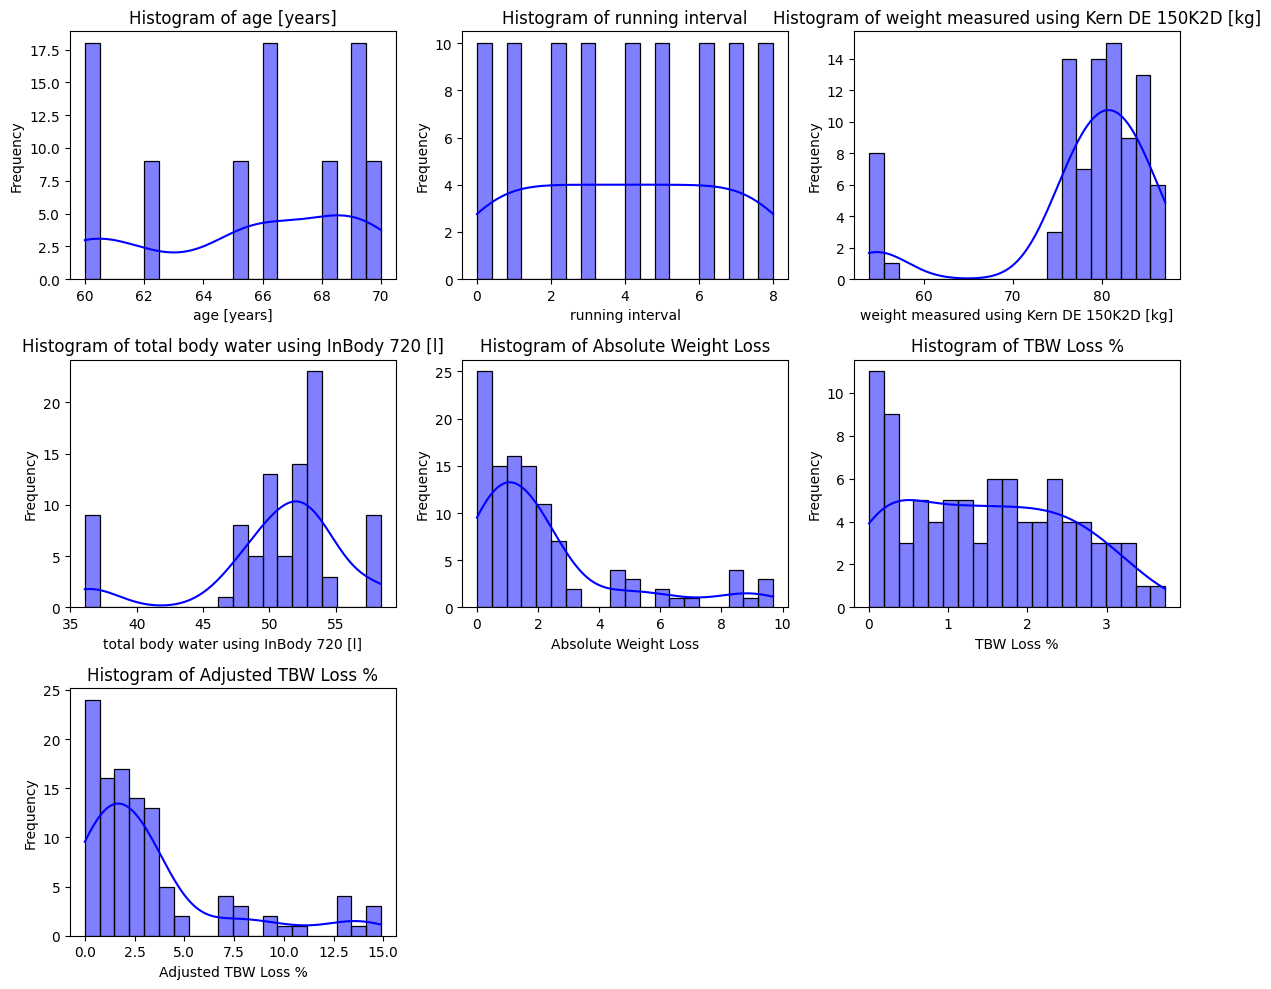

In [42]:
# Features to plot
features_to_plot = [
    'age [years]',
    'running interval',
    'weight measured using Kern DE 150K2D [kg]',
    'total body water using InBody 720 [l]',
    'Absolute Weight Loss',
    'TBW Loss %',
    'Adjusted TBW Loss %'
]

# Loop through each feature and create a histogram
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features_to_plot):
  plt.subplot(3, 3, i + 1) # Arrange subplots in a 3x3 grid
  sns.histplot(df_selected[feature], bins=20, color='blue', kde=True)
  plt.title(f'Histogram of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

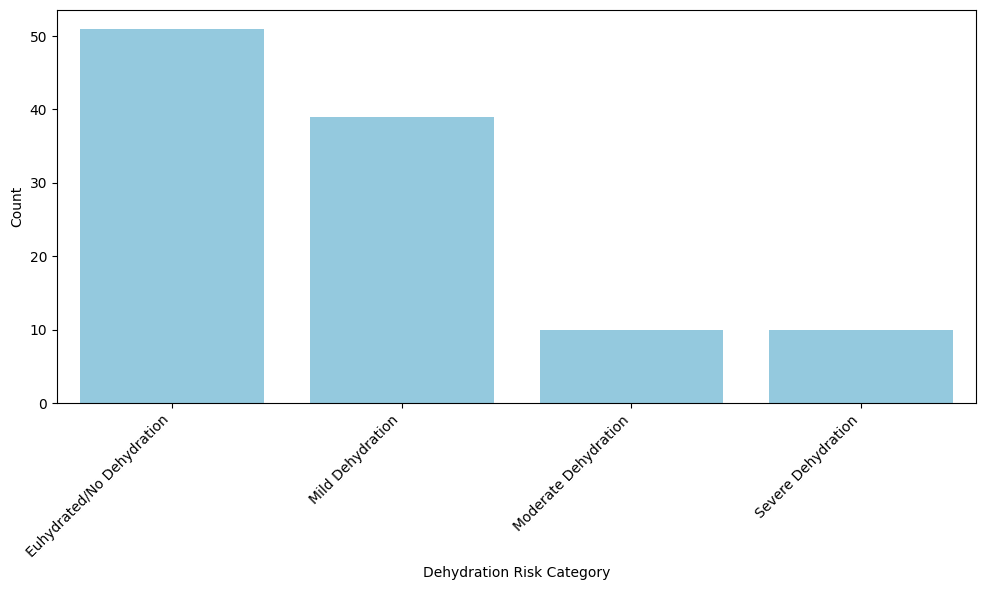

In [43]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Dehydration Risk Category', data=df_selected, order=df_selected['Dehydration Risk Category'].value_counts().index, color='skyblue')
plt.xlabel('Dehydration Risk Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

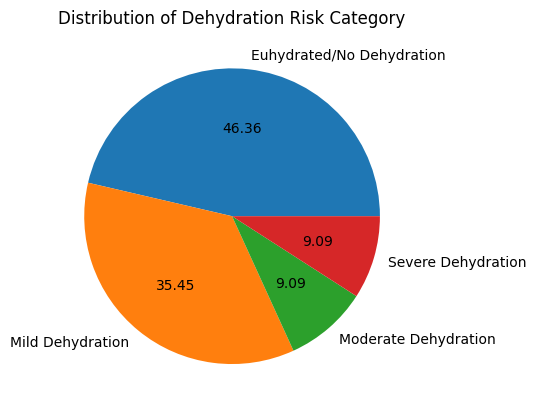

In [44]:
df_selected.groupby('Dehydration Risk Category').size().plot(kind='pie', autopct='%.2f')
plt.title('Distribution of Dehydration Risk Category')
plt.show()

# 9. Derive the Target Field

In [45]:
y = df_selected['Dehydration Risk Category Encoded']
X = df_selected.drop(['id', 'age [years]', 'running interval', 'weight measured using Kern DE 150K2D [kg]', 'total body water using InBody 720 [l]', 'Baseline Weight', 'TBW Loss %', 'Dehydration Risk Category', 'Dehydration Risk Category Encoded'], axis=1)

# Rename the 'Adjusted TBW Loss %' column
X = X.rename(columns={'Adjusted TBW Loss %': 'TBW Loss % (Elders)'})

In [46]:
X.head()

,Absolute Weight Loss,TBW Loss % (Elders)
0,0.000,0.000000
1,0.240,0.336783
2,0.620,0.870023
3,0.975,1.368181
4,1.330,1.866339


In [47]:
y.head()

,Dehydration Risk Category Encoded
0,0
1,0
2,0
3,0
4,0


# 10. Split the Data

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
X_train.head()

,Absolute Weight Loss,TBW Loss % (Elders)
65,0.565,0.799481
26,2.975,4.489437
22,1.465,2.210765
31,0.945,1.393292
47,0.445,0.693506


In [51]:
X_test.head()

,Absolute Weight Loss,TBW Loss % (Elders)
78,1.570,2.283913
10,0.245,0.337485
4,1.330,1.866339
84,0.582,1.257246
64,0.245,0.346678


In [52]:
y_train.head()

,Dehydration Risk Category Encoded
65,0
26,1
22,1
31,0
47,0


In [53]:
y_test.head()

,Dehydration Risk Category Encoded
78,1
10,0
4,0
84,0
64,0


# 11. Train the Model

In [54]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [55]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

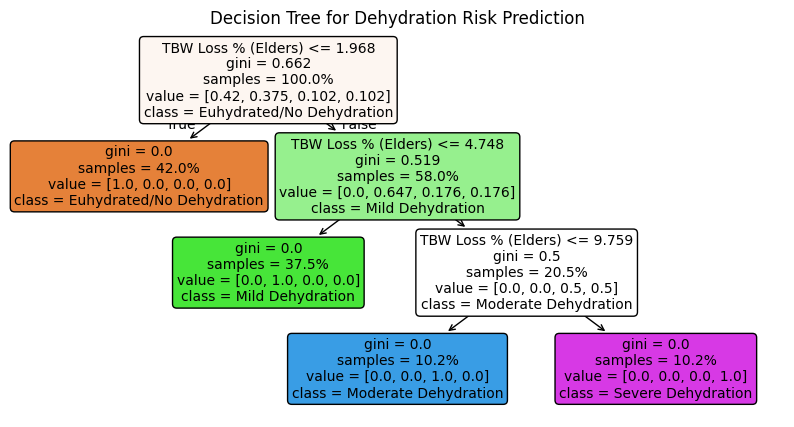

In [56]:
plt.figure(figsize=(10,5)) # Adjust figure size for better visualization
feature_names = X_train.columns.tolist()
target_names = ['Euhydrated/No Dehydration', 'Mild Dehydration', 'Moderate Dehydration', 'Severe Dehydration'] # Define class names based on your encoding

tree.plot_tree(model, filled=True, feature_names=feature_names, class_names=target_names, rounded=True, proportion=True)
plt.title("Decision Tree for Dehydration Risk Prediction")
plt.show()

# 12. Evaluate the Model

In [57]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [58]:
y_pred = model.predict(X_test)

In [59]:
y_pred[:10]

array([1, 0, 0, 0, 0, 1, 0, 0, 2, 0])

In [60]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 100.00%


In [61]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



In [62]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[14  0  0  0]
 [ 0  6  0  0]
 [ 0  0  1  0]
 [ 0  0  0  1]]


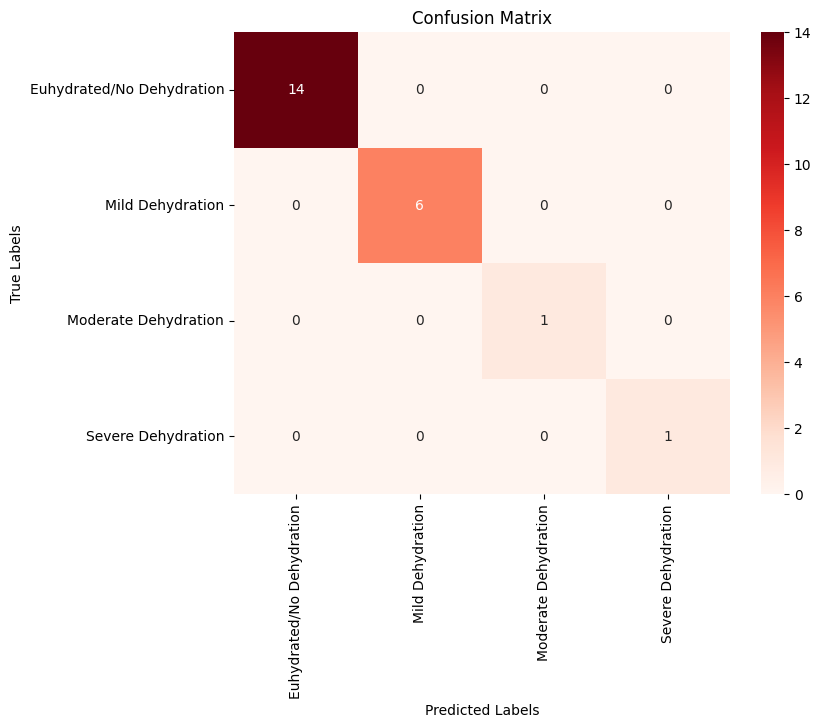

In [63]:
# Generate and visualize the confusion matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 13. Export Model

In [64]:
import joblib

In [65]:
joblib.dump(model, 'dehydration_model.pkl')

['dehydration_model.pkl']